## My own implementation of GPG

Generalized Linear Model:

$$ y(x;w) = \sum_{i} w_i \phi_{i}(x) $$

The Kriging model could then be

$$ \tilde{m}(x) = m(x) + K(x,X)(K+\sigma^2 I_N)^{-1} (f-m) $$

$$ \tilde{k}(x,x') = k(x,x') - K(x,X)(K+\sigma^2 I_N)^{-1} K(X,x') $$

$$ \tilde{\sigma}^2(x) = \tilde{k}(x,x) + \sigma^2 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Gaussian Process with RBF Kernel
class GaussianProcess:
    def __init__(self):
        self.length_scale = 1.0
        self.sigma_f = 1.0
        self.sigma_noise = 0.5

    def rbf_kernel(self, X1, X2):
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.sigma_f**2 * np.exp(-0.5 / self.length_scale**2 * sqdist)

    def train(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        self.K = self.rbf_kernel(X_train, X_train) + self.sigma_noise**2 * np.eye(len(X_train))
        self.L = np.linalg.cholesky(self.K)

    def predict(self, X_s):
        K_s = self.rbf_kernel(self.X_train, X_s)
        Lk = np.linalg.solve(self.L, K_s)
        mu_s = np.dot(Lk.T, np.linalg.solve(self.L, self.Y_train)).flatten()

        # Compute the variance at our test points.
        K_ss = self.rbf_kernel(X_s, X_s)
        s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(s2)

        return mu_s, stdv

# Negative log-likelihood for the GP model
def nll_fn(gp, X_train, Y_train):
    def nll(theta):
        # Update the model with new parameters
        gp.length_scale, gp.sigma_f, gp.sigma_noise = theta[0], theta[1], theta[2]
        gp.train(X_train, Y_train)
        K = gp.K
        L = gp.L

        # Compute the negative log likelihood
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.T.dot(np.linalg.solve(L.T, np.linalg.solve(L, Y_train))) + \
               0.5 * len(X_train) * np.log(2 * np.pi)
    return nll

## Data generation

$$ y=-cos(\pi x) + sin(\pi x) + \epsilon, \quad \epsilon \in N(0,0.4) $$

In [8]:
# Data Generation
np.random.seed(1234)
n = 100
X = np.random.rand(n, 1) * 10  # Training inputs, n x 1 vector
sigma = 0.4  # Noise standard deviation
f_true = lambda x: -np.cos(np.pi * x) + np.sin(4. * np.pi * x)
Y = f_true(X) + sigma * np.random.randn(n, 1)  # Training outputs

# ======== everything above is in a black-box, we only know X, Y ========

In [9]:
## Using my own implementation

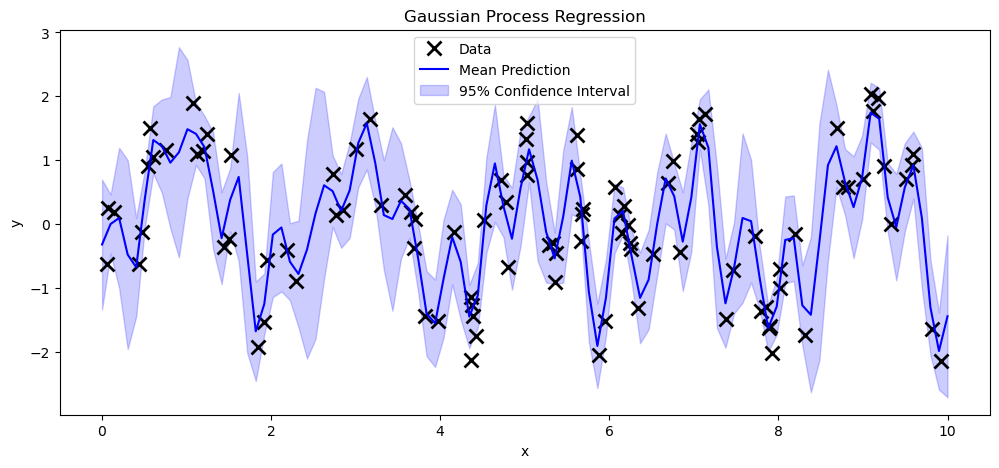

In [19]:
# Optimization of hyperparameters including sigma_noise
initial_params = [1, 1, 0.5]  # Initial guesses for length_scale, sigma_f, and sigma_noise
bounds = ((1e-5, None), (1e-5, None), (1e-5, None))  # Allow sigma_noise to vary freely

# Initialize and train GP model
gp = GaussianProcess()
res = minimize(nll_fn(gp, X, Y), initial_params, bounds=bounds, method='L-BFGS-B')

# Update GP model with optimized length scale and sigma_f
gp.length_scale, gp.sigma_f, gp.sigma_noise = res.x

# Predictions from the trained model
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
mu_s, stdv_s = gp.predict(X_test)

# Plotting the results with confidence intervals
plt.figure(figsize=(12, 5))
# plt.figure(figsize=(8,6))
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label="Data")
plt.plot(X_test, mu_s, 'b-', label='Mean Prediction')
plt.fill_between(X_test.flatten(), mu_s - 2 * stdv_s, mu_s + 2 * stdv_s, color='b', alpha=0.2, label='95% Confidence Interval')


# plt.fill_between(X_test.flatten(), mu_s - 2 * stdv_s, mu_s + 2 * stdv_s, color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title("Gaussian Process Regression")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Comparison with benchmark(GPy package)

In [11]:
import GPy

# Define the kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# Create the GP model
gp_model = GPy.models.GPRegression(X, Y, kernel)

# Optimize the model (find the best hyperparameters)
gp_model.optimize(messages=True)

# Print the optimized model's parameter values
print(gp_model)




Name : GP regression
Objective : 108.702817669132
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   1.0853182265615704  |      +ve      |        
  rbf.lengthscale          |  0.12151383247295602  |      +ve      |        
  Gaussian_noise.variance  |  0.13296135708748424  |      +ve      |        


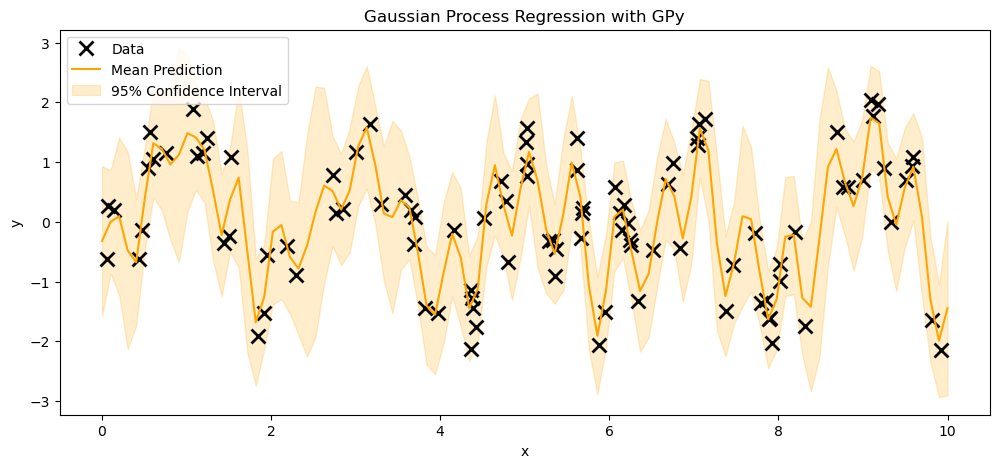

In [12]:
# Predict at new data points
X_new = np.linspace(0, 10, 100).reshape(-1, 1)  # Test inputs
Y_pred, Y_var = gp_model.predict(X_new)  # Predictive mean and variance

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label="Data")

plt.plot(X_new, Y_pred, label='Mean Prediction', color='orange')
plt.fill_between(X_new.flatten(), (Y_pred - 2*np.sqrt(Y_var)).flatten(), (Y_pred + 2*np.sqrt(Y_var)).flatten(), color='orange',
                 alpha=0.2, label='95% Confidence Interval')
plt.title("Gaussian Process Regression with GPy")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


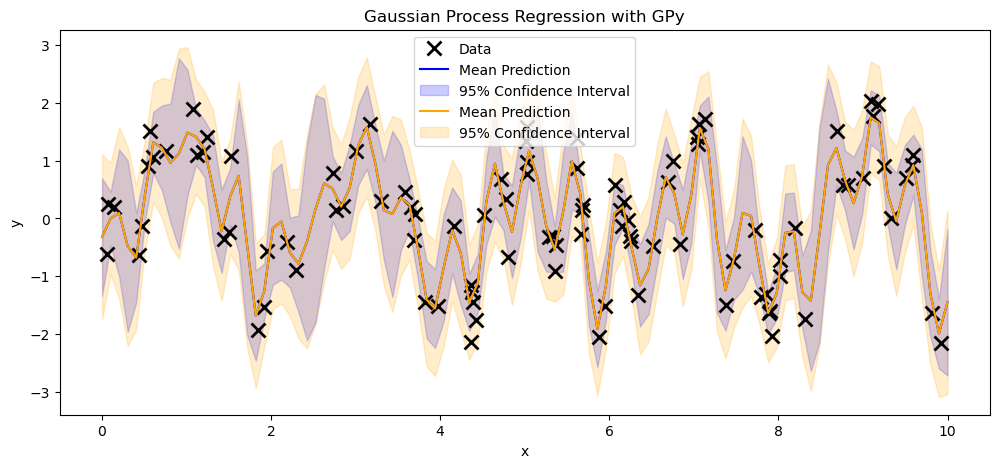

In [13]:
# Predict at new data points
X_new = np.linspace(0, 10, 100).reshape(-1, 1)  # Test inputs
Y_pred, Y_var = gp.predict(X_new)  # Predictive mean and variance

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label="Data")

plt.plot(X_test, mu_s, 'b-', label='Mean Prediction')
plt.fill_between(X_test.flatten(), mu_s - 2 * stdv_s, mu_s + 2 * stdv_s, color='b', alpha=0.2, label='95% Confidence Interval')

plt.plot(X_new, Y_pred, label='Mean Prediction', color='orange')
plt.fill_between(X_new.flatten(), (Y_pred - 2*np.sqrt(Y_var)).flatten(), (Y_pred + 2*np.sqrt(Y_var)).flatten(), color='orange',
                 alpha=0.2, label='95% Confidence Interval')
plt.title("Gaussian Process Regression with GPy")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()